# Seq2Seq Translation using skorch

This notebook demonstrates how to use the code from the [sequence-to-sequence tutorial][1] with skorch!

[1]: http://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import sklearn
import skorch

from torch.autograd import Variable

In [2]:
%matplotlib inline

### Loading data

We use the same data loading routines as the tutorial but for the
sake of brevity we will leave it out of the notebook and simply
import the code from `data.py`.

In [3]:
import data

In [4]:
input_lang, output_lang, pairs = data.prepareData('eng', 'fra', True)

Reading lines...
Read 135842 sentence pairs
Trimmed to 10853 sentence pairs
Counting words...
Counted words:
fra 4489
eng 2925


In [5]:
print(random.choice(pairs))

['je vais etre votre institutrice .', 'i m going to be your teacher .']


# Model

The seq2seq model code itself consists of the encoder and the decoder which we can use 1:1 from the example.

## Encoder

In [6]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)        
        output = embedded
        for i in range(self.n_layers):
            output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self, use_cuda):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

## Decoder

In [7]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1, max_length=data.MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_output, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)))
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        for i in range(self.n_layers):
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]))
        return output, hidden, attn_weights

    def initHidden(self, use_cuda):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

## Glue

In the original code the encoder and decoder are combined in the training and
evaluation code. We refrain from doing this and define a `Seq2Seq`-model that
unites both and allows us to have a single point of entry and avoids code
duplication for inference and training.

In [8]:
def params_for(prefix, kwargs):
    if not prefix.endswith('__'):
        prefix += '__'
    return {key[len(prefix):]: val for key, val in kwargs.items()
            if key.startswith(prefix)}

In [9]:
class Seq2Seq(nn.Module):
    def __init__(
        self, 
        encoder, 
        decoder,
        teacher_forcing_ratio=0.5,
        hidden_size=256,
        max_length=data.MAX_LENGTH,
        **kwargs
    ):
        super().__init__()
        self.encoder = encoder(hidden_size=hidden_size, **params_for('encoder', kwargs))
        self.decoder = decoder(hidden_size=hidden_size, **params_for('decoder', kwargs))
        self.max_length = max_length
        self.teacher_forcing_ratio = teacher_forcing_ratio
        
    def forward(self, x, y=None):
        # Encode the input x to the thought vector stored in encoder_outputs.
        encoder_hidden = self.encoder.initHidden(use_cuda=x.is_cuda)
        encoder_outputs = Variable(torch.zeros(self.max_length, self.encoder.hidden_size))
        encoder_outputs = encoder_outputs.cuda() if x.is_cuda else encoder_outputs
                
        for ei in range(x.size(1)):
            encoder_output, encoder_hidden = self.encoder(x[0, ei], encoder_hidden)
            encoder_outputs[ei] = encoder_output[0][0]

        use_teacher_forcing = y is not None and random.random() < self.teacher_forcing_ratio
        ys = []
                
        target_length = self.max_length if y is None else y.size(1)
        target_variable = y
        
        # Decode the thought vector into the target sequence beginning with a 
        # start-of-sentence (SOS) token.
        decoder_input = Variable(torch.LongTensor([[data.SOS_token]]))                                               
        decoder_input = decoder_input.cuda() if x.is_cuda else decoder_input                                     
        decoder_hidden = encoder_hidden
                
        if use_teacher_forcing:
            # Teacher forcing: Feed the target as the next input
            for di in range(target_length):
                decoder_output, decoder_hidden, decoder_attention = self.decoder(
                    decoder_input, decoder_hidden, encoder_output, encoder_outputs)
                ys.append(decoder_output)
                decoder_input = target_variable[0, di]  # Teacher forcing

        else:
            # Without teacher forcing: use its own predictions as the next input
            for di in range(target_length):
                decoder_output, decoder_hidden, decoder_attention = self.decoder(
                    decoder_input, decoder_hidden, encoder_output, encoder_outputs)
                topv, topi = decoder_output.data.topk(1)
                ni = topi[0][0]

                decoder_input = Variable(torch.LongTensor([[ni]]))
                decoder_input = decoder_input.cuda() if x.is_cuda else decoder_input

                ys.append(decoder_output)
                if ni == data.EOS_token:
                    break
                    
        return torch.stack(ys, dim=1)

# Training

After defining the necessary components we can prepare everything for the training itself.

### Prerequisites

Some fluff taken 1:1 from the original code.

In [10]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def variableFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(data.EOS_token)
    result = Variable(torch.LongTensor(indexes).view(-1, 1))
    if use_cuda:
        return result.cuda()
    else:
        return result
    

def variablesFromPair(pair):
    input_variable = variableFromSentence(input_lang, pair[0])
    target_variable = variableFromSentence(output_lang, pair[1])
    return (input_variable, target_variable)

### Wrapping the seq2seq model in skorch

Now we can wrap our model into a `skorch.NeuralNet` where we 
define how our seq2seq model is trained. For this we need only a few things:

1. A proper loss
2. The training step (data flow in and out of the model)

Since we are dealing with variable length sequences produced
by the model we also have to deal with those in the evaluation step,
namely `predict` and `predict_proba` where we can solve this issue 
by returning a sequence that is padded to a fixed length.

Another extra is that the tutorial uses two separate optimizers for
the encoder and the decoder. We can implement this as well, even though
it does not make a difference with SGD, it might make a difference when
using Adam, for example. We can evaluate this difference by doing a 
grid search over the possible optimizer encoders. For this we will
need a `score()` function as well.

In [11]:
class Trainer(skorch.NeuralNet):
    
    def __init__(
        self, 
        *args, 
        optimizer_encoder=torch.optim.SGD, 
        optimizer_decoder=torch.optim.SGD,
        **kwargs
    ):
        self.optimizer_encoder = optimizer_encoder
        self.optimizer_decoder = optimizer_decoder
        super().__init__(*args, **kwargs)
    
    def initialize_optimizer(self):
        kwargs = self._get_params_for('optimizer_encoder')
        self.optimizer_encoder_ = self.optimizer_encoder(self.module_.encoder.parameters(), **kwargs)
        kwargs = self._get_params_for('optimizer_decoder')
        self.optimizer_decoder_ = self.optimizer_decoder(self.module_.decoder.parameters(), **kwargs)

    def train_step(self, Xi, yi):
        self.module_.train()
        
        self.optimizer_encoder_.zero_grad()
        self.optimizer_decoder_.zero_grad()

        y_pred = self.infer(Xi, yi)
        loss = self.get_loss(y_pred, yi, X=Xi, train=True)
        loss.backward()
        
        self.optimizer_encoder_.step()
        self.optimizer_decoder_.step()
        
        return loss

    def infer(self, Xi, yi=None):
        Xi = skorch.utils.to_var(Xi, use_cuda=self.use_cuda)
        yi = skorch.utils.to_var(yi, use_cuda=self.use_cuda) if yi is not None else None
        return self.module_(Xi, yi)
    
    def get_loss(self, y_pred, y_true, **kwargs):
        y_true = y_true[:, :y_pred.size(1)]        
        y_pred_flat = y_pred.view(y_pred.size(0) * y_pred.size(1), -1)
        y_true_flat = y_true.view(y_true.size(0) * y_true.size(1))
        
        return super().get_loss(
            y_pred_flat,
            y_true_flat,
            **kwargs)
    
    def _predict(self, X, most_probable=True):
        # return either predicted word probabilities or the most probable 
        # word using argmax.
        y_probas = []
        for yp in self.forward_iter(X, training=False):
            if most_probable:
                pad = np.zeros((yp.size(0), data.MAX_LENGTH))
                pad[:, :yp.size(1)] = skorch.utils.to_numpy(yp.max(-1)[-1])
            else:
                pad = np.zeros((yp.size(0), data.MAX_LENGTH, yp.size(-1)))
                pad[:, :yp.size(1)] = skorch.utils.to_numpy(yp)
            y_probas.append(pad)
        y_proba = np.concatenate(y_probas, 0)
        return y_proba
    
    def predict_proba(self, X):
        return self._predict(X, most_probable=False)
    
    def predict(self, X):
        return self._predict(X, most_probable=True)
    
    def score(self, X, y):
        y_pred = self.predict(X)
        y_true = y_pred.copy()
        
        for i, yi in enumerate(y):
            yi = skorch.utils.to_numpy(yi.squeeze())
            y_true[:, :len(yi)] = yi
        
        return sklearn.metrics.accuracy_score(y_true.flatten(), y_pred.flatten())
    

### Running the training process

In [25]:
n_iters = 75000
use_cuda = True
training_pairs = [variablesFromPair(random.choice(pairs)) for i in range(n_iters)]

We can now instantiate the `Trainer` with the parameters we want to train our model with:

In [28]:
trainer = Trainer(
    criterion=torch.nn.NLLLoss,
    
    # We extended the trainer to support two optimizers
    # but to get the behavior of one optimizer we can 
    # simply use SGD for both, just like in the tutorial.
    optimizer_encoder=torch.optim.SGD,
    optimizer_encoder__lr=0.01,
    optimizer_decoder=torch.optim.SGD,
    optimizer_decoder__lr=0.01,
    
    module=Seq2Seq,
    module__hidden_size=256,

    module__encoder=EncoderRNN,
    module__encoder__input_size=input_lang.n_words,
    
    module__decoder=AttnDecoderRNN,
    module__decoder__output_size=output_lang.n_words,
    module__decoder__dropout_p=0.1,
    
    # We have no internal validation.
    train_split=None,
    
    # The decoding code is not meant to be batched
    # so we have to deal with a batch size of 1 for
    # both training and validation/prediction.
    iterator_train__batch_size=1,
    iterator_valid__batch_size=1,
    
    # Training takes a long time, add a progress bar
    # to see how far in we are.
    callbacks=[
        skorch.callbacks.ProgressBar(),
    ],
    
    use_cuda=use_cuda,
    max_epochs=1,
)

In [29]:
# TODO: remove this once #118 is merged
trainer.initialize();

And finally we fit the seq2seq model by calling `.fit` on the trainer.

In [30]:
X = np.array([n[0].data for n in training_pairs])
y = np.array([n[1].data for n in training_pairs])

In [31]:
from sklearn.model_selection import GridSearchCV

In [32]:
params = {
    'optimizer_encoder': [torch.optim.SGD, torch.optim.Adam],
    'optimizer_decoder': [torch.optim.SGD, torch.optim.Adam],
}

In [33]:
gs = GridSearchCV(trainer, params)

In [ ]:
%pdb on
gs.fit(X, y)

Automatic pdb calling has been turned ON
Re-initializing module!


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [20]:
ef = gs.best_estimator_

# Results

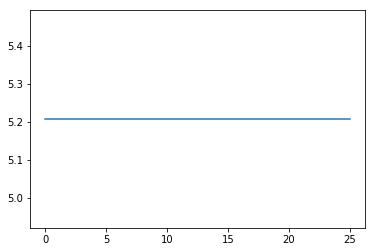

In [21]:
N = 100
plt.plot(np.convolve(ef.history[:,'batches',:,'train_loss'][0], np.ones((N,))/N, mode='valid'))

In [22]:
eval_data = X[:10]
pred = ef.predict(eval_data)
pred_proba = ef.predict_proba(eval_data)

In [23]:
for (sent_in, sent_out) in zip(eval_data, pred):
    print([input_lang.index2word.get(w[0], '???') for w in sent_in])
    print([output_lang.index2word[w] for w in sent_out])
    print()

['vous', 'etes', 'tous', 'heureux', '.', 'EOS']
['you', 'you', '.', '.', 'EOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS']

['je', 'ne', 'suis', 'pas', 'suppose', 'boire', '.', 'EOS']
['i', 'i', 'i', '.', '.', 'EOS', 'SOS', 'SOS', 'SOS', 'SOS']

['il', 'est', 'quelque', 'peu', 'timide', '.', 'EOS']
['i', 'i', '.', '.', '.', 'EOS', 'SOS', 'SOS', 'SOS', 'SOS']

['il', 'y', 'travaille', '.', 'EOS']
['i', 'i', '.', '.', 'EOS', 'SOS', 'SOS', 'SOS', 'SOS', 'SOS']

['je', 'ne', 'suis', 'dans', 'le', 'camp', 'de', 'personne', '.', 'EOS']
['i', 'i', 'i', '.', '.', 'EOS', 'SOS', 'SOS', 'SOS', 'SOS']

['nous', 'sommes', 'tous', 'la', '.', 'EOS']
['i', 'i', '.', '.', '.', 'EOS', 'SOS', 'SOS', 'SOS', 'SOS']

['ils', 's', 'amusent', '.', 'EOS']
['i', 'i', '.', '.', '.', 'EOS', 'SOS', 'SOS', 'SOS', 'SOS']

['il', 'est', 'toujours', 'cloue', 'au', 'lit', '.', 'EOS']
['i', 'i', '.', '.', '.', 'EOS', 'SOS', 'SOS', 'SOS', 'SOS']

['j', 'echoue', 'dans', 'mon', 'travail', '.', 'EOS']
['i', 'i', 'i', '.', '.', '.'

In [24]:
pred_proba.argmax(-1)

array([[130, 130,   4,   4,   1,   0,   0,   0,   0,   0],
       [  2,   2,   2,   4,   4,   1,   0,   0,   0,   0],
       [  2,   2,   4,   4,   4,   1,   0,   0,   0,   0],
       [  2,   2,   4,   4,   1,   0,   0,   0,   0,   0],
       [  2,   2,   2,   4,   4,   1,   0,   0,   0,   0],
       [  2,   2,   4,   4,   4,   1,   0,   0,   0,   0],
       [  2,   2,   4,   4,   4,   1,   0,   0,   0,   0],
       [  2,   2,   4,   4,   4,   1,   0,   0,   0,   0],
       [  2,   2,   2,   4,   4,   4,   1,   0,   0,   0],
       [  2,   2,   4,   4,   1,   0,   0,   0,   0,   0]])